In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal, ndimage, misc

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Convolution3D, UpSampling3D, MaxPooling3D
from keras.models import Model
from keras import regularizers
from keras import backend as K_backend
from keras import objectives
from keras.datasets import mnist
from keras.utils import np_utils

import ipyvolume as ipv

import autoencoder

# Need this because otherwise the progbar freezes my Jupyter
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

In [50]:
from keras.layers import Activation, Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout
from keras.layers import Conv1D, Conv2D, UpSampling1D, UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K_backend
from keras import objectives
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

class Autoencoder(object):
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100): # size of minibatch
        self.model = None
        self.encoder = None
        self.generator = None
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        assert K_backend.image_dim_ordering() == 'tf', 'Cannot support Theano ordering! Use TF ordering! #tensorflowmasterrace'
        
    def unroll_decoder(self, z, z_input, layers_list):
        """Takes a list of Keras layers and returns the decoder back-half and the standalone decoder model"""
        ae = AE_Dec()
        dc = AE_Dec()
        last_ae = z
        last_dc = z_input
        for i, layer in enumerate(layers_list):
#             if i ==0:
            last_ae = layer(last_ae)
            last_dc = layer(last_dc)
        return last_ae, last_dc
        
class AE_Dec(object):
    def __init__(self):
        pass
    
    

class VAE(Autoencoder):
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100,  # size of minibatch
                 epsilon_std=1.0):  # This is the stddev for our normal-dist sampling of the latent vector):
        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size)
        # Necessary to instantiate this as instance variables such that they can be passed to the loss function (internally), since loss functions are 
        # all of the form lossfn(y_true, y_pred)
        self.epsilon_std = epsilon_std
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)

        # input image dimensions
        self.input_shape = input_shape
        if len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        elif len(input_shape) == 1:
            self.img_rows = input_shape[0] # todo: test this
        else:
            raise ValueError("Invalid input shape: {}".format(input_shape))


    def sampling(self, args):
        # Forging our latent vector from the reparameterized mean and std requires some sampling trickery
        # that admittedly I do not understand in the slightest at this point in time
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                          mean=0., std=self.epsilon_std)
        # We return z_mean + epsilon*sigma^2. Not sure why we use log var
        # Basically, create a random variable vector from the distribution
        # We are learning a distribution (mu, var) which represents the input
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_decoded_mean):
        # Custom loss function for VAE. More VAE voodoo
        # FC: NOTE: binary_crossentropy expects a shape (batch_size, dim)
        # FC: for x and x_decoded_mean, so we MUST flatten these!
        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        shape_coef = self.img_rows * self.img_cols # this needs an update for dimensionality!
        xent_loss =  shape_coef * objectives.binary_crossentropy(x, x_decoded_mean) 
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        # Kullback–Leibler divergence. so many questions about this one single line
        return xent_loss + kl_loss

In [60]:
class Convo3d(object):
    def __init__(self, input_shape=(28, 28, 28, 1), n_classes=10, n_filters=4):
        """
        5D tensor with shape: (samples, channels, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th' or 
        5D tensor with shape: (samples, conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'.
        """
#         input_img = Input(shape=(1, 28, 28, 28)) # th =(nChan, nFrames, xPix, yPix) or (nChan, z, x, y)
        input_img = Input(shape=input_shape) # th =(nChan, nFrames, xPix, yPix) or (nChan, z, x, y)
        img_chans = 1
        

        
        x = Convolution3D(n_filters, 3, 3, 3, activation='relu', border_mode='same')(input_img)
        x = MaxPooling3D((2, 2, 2), border_mode='same')(x)
        x = Convolution3D(n_filters*8, 3, 3, 3, activation='relu', border_mode='same')(x)
        x = MaxPooling3D((2, 2, 2), border_mode='same')(x)
        x = Convolution3D(n_filters*16, 3, 3, 3, activation='relu', border_mode='same')(x)
        pooled = MaxPooling3D((2, 2, 2), border_mode='same')(x)
        self.pooled = pooled
        # at this point the representation is (4, 4, 4, 8) i.e. 512-dimensional
#         print('Pooled shape: ', pooled.shape)
        flat = Flatten()(pooled)
#         z = Dense(n_classes)
        classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(flat)
    
        self.z = pooled # hack
        x = Convolution3D(n_filters*16, 3, 3, 3, activation='relu', border_mode='same')(self.z)
        x = UpSampling3D((2, 2, 2))(x)
        x = Convolution3D(n_filters*8, 3, 3, 3, activation='relu', border_mode='same')(x)
        x = UpSampling3D((2, 2, 2))(x)
#         x = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='valid')(x)
        x = UpSampling3D((2, 2, 2))(x)
        # smash the extra channels down
        x = Convolution3D(img_chans, 3, 3, 3, activation='sigmoid', border_mode='same')(x)
#         print(input_shape)
#         x = Dense(input_shape)(x) # fudge to fix output shape
        self.decoded = x
        self.autoencoder = Model(input_img, self.decoded)
        
        self.classifier = Model(input_img, classer_base)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        

In [56]:
class Vae3D(VAE):
    def __init__(self, input_shape=(28, 28, 28, 1), n_classes=10, n_filters=4):
        """
        5D tensor with shape: (samples, channels, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th' or 
        5D tensor with shape: (samples, conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'.
        """
#         input_img = Input(shape=(1, 28, 28, 28)) # th =(nChan, nFrames, xPix, yPix) or (nChan, z, x, y)
        T, U, V, CH = input_shape
        input_img = Input(shape=input_shape) # th =(nChan, nFrames, xPix, yPix) or (nChan, z, x, y)
        img_chans = 1
        

        
        x = Convolution3D(n_filters, 3, 3, 3, activation='relu', border_mode='same')(input_img)
        x = MaxPooling3D((2, 2, 2), border_mode='same')(x)
        x = Convolution3D(n_filters*8, 3, 3, 3, activation='relu', border_mode='same')(x)
        x = MaxPooling3D((2, 2, 2), border_mode='same')(x)
        x = Convolution3D(n_filters*16, 3, 3, 3, activation='relu', border_mode='same')(x)
        pooled = MaxPooling3D((2, 2, 2), border_mode='same')(x)

        # at this point the representation is (4, 4, 4, 8) i.e. 512-dimensional
        flat = Flatten()(pooled)
        
        hidden_1 = Dense(latent_dim*2, activation='relu', name='intermezzo')(flat) # CNN conversion layer, not really necessary here
        # One weird VAE trick
        z_mean = Dense(latent_dim, name='Z_mean')(hidden_1)
        z_log_var = Dense(latent_dim, name='Z_log_var')(hidden_1)
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])

#         classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(flat)
        dec_hidden = Dense(latent_dim*2, activation='relu', name='Dec_intermezzo')
        decoder_upsample = Dense(filters * (T*U*V/8), activation='relu')
        
        decoder_reshape = Reshape(output_shape[1:])

        dec_cnn_3 = Convolution3D(n_filters*16, 3, 3, 3, activation='relu', border_mode='same')
        dec_ups_3 = UpSampling3D((2, 2, 2))
        dec_cnn_2 = Convolution3D(n_filters*8, 3, 3, 3, activation='relu', border_mode='same')
        dec_ups_2 = UpSampling3D((2, 2, 2))
#         x = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='valid')(x)
        dec_cnn_1 = UpSampling3D((2, 2, 2))
        # smash the extra channels down
        dec_ups_1 = Convolution3D(img_chans, 3, 3, 3, activation='sigmoid', border_mode='same')
#         print(input_shape)
#         x = Dense(input_shape)(x) # fudge to fix output shape
        layers_list = []
        self.decoded = x
        self.autoencoder = Model(input_img, self.decoded)
        
        self.classifier = Model(input_img, classer_base)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        

In [32]:
datas = []
basepath = '/media/mike/tris/data/bowl17/luna/volumes_48/'
for n in ['c', 'p']:
    for i in range(3):
        path = basepath + 'tumor_{}_volumes{:02}.npy'.format(n, i)
        try:
            f = np.load(path)
            print(f.shape)
            datas.append(f)
        except FileNotFoundError:
            pass
    
data = np.concatenate(datas, axis=0)
# data = np.array(data, dtype='int16')
data.shape, data.dtype

(99, 48, 48, 48)
(99, 48, 48, 48)
(100, 48, 48, 48)
(1976, 48, 48, 48)
(1996, 48, 48, 48)


((4270, 48, 48, 48), dtype('int16'))

In [61]:
ae_base = Convo3d(input_shape=(48,48,48,1), n_filters=8)


In [69]:
s = ae_base.pooled
l = s(Dense(12))
# s.concatenate()

TypeError: 'Tensor' object is not callable

In [62]:
ae_base.autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 48, 48, 48, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_26 (Convolution3D) (None, 48, 48, 48, 8) 224         input_6[0][0]                    
____________________________________________________________________________________________________
maxpooling3d_16 (MaxPooling3D)   (None, 24, 24, 24, 8) 0           convolution3d_26[0][0]           
____________________________________________________________________________________________________
convolution3d_27 (Convolution3D) (None, 24, 24, 24, 64 13888       maxpooling3d_16[0][0]            
___________________________________________________________________________________________

In [43]:
ae_base.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [44]:
data = data.reshape((len(data), 48, 48, 48))

In [45]:
x_train = data.reshape((len(data), 48, 48, 48, 1))
print(x_train.shape)

(4270, 48, 48, 48, 1)


In [46]:
ae_base.autoencoder.fit(x_train, x_train, batch_size=20, nb_epoch=10, verbose=0, callbacks=[TQDMNotebookCallback()])

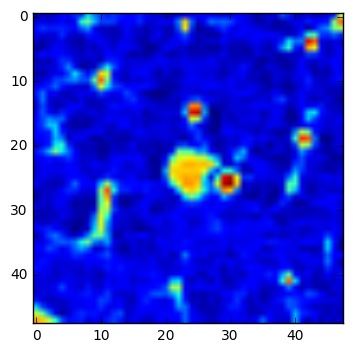

In [47]:
plt.imshow(data[3][24])

In [48]:
pred = ae_base.autoencoder.predict(x_train, batch_size=20)

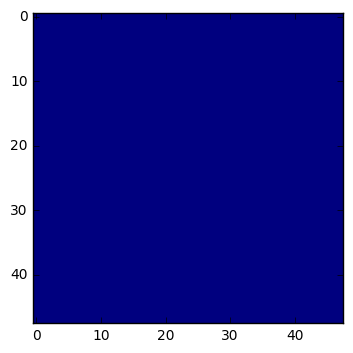

In [49]:
plt.imshow(pred[3].reshape((48,48,48))[24])